In [437]:
import torch
import numpy as np
import utils.gradientUtils as gu
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d

#cuda devices
device = torch.device("cuda:0")
print("Using device: ", torch.cuda.get_device_name(device))


threshold = 1e-9
max_iter = 500
learning_rate = 0.03

radius = 3.0
origin=torch.tensor([5.0, 5.0], device=device)
side_length=4.0

sdf = 'circle'
#sdf = 'box'


destination = "./images/autograd/multiple_sites/"

Using device:  NVIDIA GeForce RTX 3090


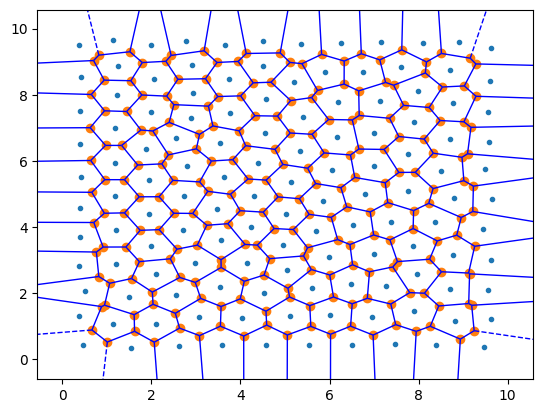

In [438]:
# Python code for creating a CVT
# Vassilis Vassiliades - Inria, Nancy - April 2018

import numpy as np
import matplotlib.pyplot as plt
import sys
from sklearn.cluster import KMeans
import argparse

# Default values
num_centroids = 128
dimensionality = 2
num_samples = 100000
num_replicates = 1
max_iterations = 100000
tolerance = 0.00001
verbose = True

X = np.random.rand(num_samples,dimensionality)

kmeans = KMeans(
    init='k-means++', 
    n_clusters=num_centroids, 
    n_init=num_replicates, 
    #n_jobs=-1, 
    max_iter=max_iterations, 
    tol=tolerance,
    verbose=0)

kmeans.fit(X)
centroids = kmeans.cluster_centers_
vor = Voronoi(centroids*10)
fig, ax = plt.subplots()
voronoi_plot_2d(vor, ax=ax, show_vertices=True, line_colors='blue')
# Plot the points
plt.savefig('CVT_'f'{num_centroids}''.png',transparent=True)
plt.show()


In [439]:
centroids = np.array(centroids) * 10.0
sites = torch.from_numpy(centroids).to(device).requires_grad_(True)


#torch.manual_seed(30)
#sites = torch.rand(11, 2, dtype=torch.float32,device=device, requires_grad=True)

#sites = sites * 10.0
print(sites)


tensor([[4.5657, 0.4394],
        [1.9918, 9.4985],
        [8.3755, 4.1418],
        [2.7149, 3.8981],
        [2.8859, 7.2985],
        [7.8909, 7.1807],
        [7.8986, 1.4466],
        [2.0952, 1.0753],
        [5.2110, 8.3831],
        [1.1795, 5.9291],
        [5.9857, 3.0934],
        [8.7084, 8.7591],
        [5.1359, 5.3592],
        [1.2080, 2.8742],
        [9.6218, 2.9941],
        [0.3693, 9.4990],
        [6.1677, 6.7095],
        [9.4812, 5.7466],
        [7.9593, 2.5636],
        [6.7533, 8.6797],
        [4.1485, 2.9160],
        [9.4617, 0.3800],
        [2.8024, 5.8493],
        [3.6638, 9.5174],
        [5.0273, 4.4041],
        [6.0203, 1.3296],
        [0.4650, 0.4140],
        [4.5423, 6.8503],
        [0.3891, 7.5026],
        [6.7875, 4.9946],
        [0.4022, 3.6832],
        [7.4665, 0.4661],
        [8.0922, 9.5686],
        [1.2052, 3.9101],
        [6.5062, 0.4362],
        [4.3910, 5.9484],
        [6.2482, 9.5578],
        [2.5581, 1.9290],
        [9.5

In [440]:
def get_delaunay_neighbors_list(sites):
    # Detach and convert to NumPy for Delaunay triangulation
    points_np = sites.detach().cpu().numpy()
    
    # Compute the Delaunay triangulation
    tri = Delaunay(points_np)

    # Find the neighbors of each point
    neighbors = {i: set() for i in range(len(points_np))}
    for simplex in tri.simplices:
        # Each simplex is a triangle of three points; each point is a neighbor of the other two
        for i in range(3):
            for j in range(i + 1, 3):
                neighbors[simplex[i]].add(simplex[j])
                neighbors[simplex[j]].add(simplex[i])

    # Convert neighbor sets to lists for easier reading
    neighbors = {key: list(value) for key, value in neighbors.items()}
    return neighbors


In [441]:
def compute_vertices_index(neighbors):
    vertices_index_to_compute = []
    for site, adjacents in neighbors.items():
        for i in adjacents:
            for n in adjacents:
                if n != site and n != i and n in neighbors[i]:              
                    vertices_index_to_compute.append([i,site,n])
            
    # Set to store the canonical (sorted) version of each triplet
    seen_triplets = set()
    # Filtered list to store the unique triplets
    filtered_triplets = []
    # Process each triplet and keep only one permutation
    for triplet in vertices_index_to_compute:
        # Convert the triplet to a canonical form by sorting it
        canonical_triplet = tuple(sorted(triplet, key=str))
        # Check if this canonical triplet has been seen before
        if canonical_triplet not in seen_triplets:
            # If not seen, add it to the set and keep the triplet
            seen_triplets.add(canonical_triplet)
            filtered_triplets.append(triplet)

    return filtered_triplets

In [442]:
def compute_vertex(s_i, s_j, s_k):
    # Unpack coordinates for each site
    x_i, y_i = s_i[0], s_i[1]
    x_j, y_j = s_j[0], s_j[1]
    x_k, y_k = s_k[0], s_k[1]
    
    # Calculate numerator and  for x coordinate
    n_x = (
        x_i**2 * (y_j - y_k)
        - x_j**2 * (y_i - y_k)
        + (x_k**2 + (y_i - y_k) * (y_j - y_k)) * (y_i - y_j)
    )

    # Calculate numerator for y coordinate
    n_y = -(
        x_i**2 * (x_j - x_k)
        - x_i * (x_j**2 - x_k**2 + y_j**2 - y_k**2)
        + x_j**2 * x_k
        - x_j * (x_k**2 - y_i**2 + y_k**2)
        - x_k * (y_i**2 - y_j**2)
    )
    
    # Calculate denominator 
    d = 2 * (x_i * (y_j - y_k) - x_j * (y_i - y_k) + x_k * (y_i - y_j))
    
    # Calculate x and y coordinates
    x = n_x / d
    y = n_y / d

    # Return x, y as a tensor to maintain the computational graph
    return torch.stack([x, y])


In [443]:
def compute_all_vertices(sites, vertices_to_compute):
    # Initialize an empty tensor for storing vertices
    vertices = []
    
    for triplet in vertices_to_compute:
        si = sites[triplet[0]]
        sj = sites[triplet[1]]
        sk = sites[triplet[2]]
        
        # Compute vertex for the triplet (si, sj, sk)
        v = compute_vertex(si, sj, sk)
        
        # Append to the list
        vertices.append(v)
    
    # Stack the list of vertices into a single tensor for easier gradient tracking
    vertices = torch.stack(vertices)
    return vertices


In [444]:
def circle_sdf_loss(vertices, radius=1.0, origin=torch.tensor([0.0, 0.0])):
    # Calculate the Euclidean distance of each vertex to the specified origin
    distances = torch.norm(vertices - origin, dim=1)  # L2 norm along x and y for each vertex
    
    # Calculate the SDF value: distance to origin minus the circle radius
    sdf_values = distances - radius
    return sdf_values


In [445]:
def box_sdf_loss(vertices, side_length=4.0):
    # Calculate half side length (since box is centered at origin)
    half_side = side_length / 2.0
    
    # Compute the signed distance to the box for each vertex
    dx = torch.clamp(torch.abs(vertices[:, 0]) - half_side, min=0)  # Distance from x-axis bounds
    dy = torch.clamp(torch.abs(vertices[:, 1]) - half_side, min=0)  # Distance from y-axis bounds
    
    # Calculate the SDF as the Euclidean distance from the nearest box boundary
    sdf_values = torch.sqrt(dx**2 + dy**2)
    return sdf_values


In [446]:
def min_distance_regularization(sites):
    # Compute pairwise distances between all sites
    distances = torch.cdist(sites, sites, p=2)
    
    # Create a mask to ignore distances between a site and itself
    mask = torch.eye(distances.size(0), device=distances.device).bool()
    distances = distances.masked_fill(mask, float("inf"))

    # Calculate minimum distance for each site
    min_distances = distances.min(dim=1).values  # Minimum distance to another site for each site

    # Calculate the average of these minimum distances
    avg_min_distance = min_distances.mean()

    # Calculate penalties based on the condition provided
    #penalties = torch.clamp(min_distances - avg_min_distance, min=0)

    penalties = min_distances - avg_min_distance


    # Sum the penalties to get the regularization loss
    regularization_loss = torch.sum(penalties**2)
    
    return regularization_loss



In [447]:
def create_dynamic_mask(sdf_values):
    # Calculate the mean and standard deviation of the SDF values
    mean_sdf = sdf_values.mean()
    std_sdf = sdf_values.std()
    
    # Define a dynamic threshold based on the mean and standard deviation
    # For example, consider vertices within one standard deviation of the mean
    lower_threshold = mean_sdf - std_sdf
    upper_threshold = mean_sdf + std_sdf
    
    # Create a mask where SDF values fall within the dynamic range
    mask = (sdf_values > lower_threshold) & (sdf_values < upper_threshold)
    
    return mask.float()  # Convert boolean mask to float for further use


In [448]:
def autograd(sites, learning_rate=learning_rate, max_iter=max_iter, threshold=threshold, radius=radius):
    optimizer = torch.optim.Adam([sites], lr=learning_rate)
    prev_loss = float("inf")
    
    for epoch in range(max_iter):
        optimizer.zero_grad()
        
       
        neighbors = get_delaunay_neighbors_list(sites)
        vertices_to_compute = compute_vertices_index(neighbors)
        vertices = compute_all_vertices(sites,vertices_to_compute)
                
        if sdf == 'circle':
            sdf_values = circle_sdf_loss(vertices, radius=radius, origin=origin)
        elif sdf == 'box':
            sdf_values = box_sdf_loss(vertices)
        
        sdf_mask = create_dynamic_mask(sdf_values)
        masked_loss = (sdf_values ** 2 * sdf_mask).sum() / sdf_mask.sum()  # Normalize by the number of selected vertices
        
        # regularization loss        
        min_distance_loss = min_distance_regularization(sites)
        
        # Total loss
        loss = masked_loss + min_distance_loss
        #loss = torch.mean(sdf_values**2) + min_distance_loss

        loss.backward()
        optimizer.step()
        
        if epoch % 100 == 0:
            print(f"Epoch {epoch}: loss = {loss.item()}")
        if abs(prev_loss - loss.item()) < threshold:
            break
        prev_loss = loss.item()
        
    return sites

In [449]:
def plot_sdf(ax):
    #plot the sdf function
    if sdf == 'circle':
        circle = plt.Circle(origin.detach().cpu().numpy(), radius, color='black', fill=False)
        ax.add_artist(circle)
    elif sdf == 'box':
        rect = plt.Rectangle((5, 5), side_length, side_length/2, fill=False, color='black')
        ax.add_artist(rect)

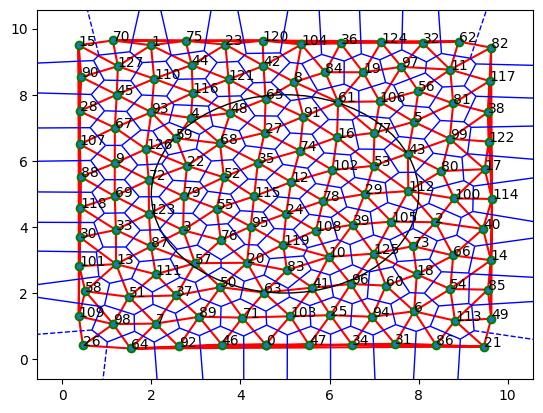

In [450]:
sites_np = sites.detach().cpu().numpy()
tri = Delaunay(sites_np)
voronoi_initial = Voronoi(sites_np)
fig, ax = plt.subplots()
voronoi_plot_2d(voronoi_initial, ax=ax, show_vertices=False, line_colors='blue')
ax.triplot(sites_np[:, 0], sites_np[:, 1], tri.simplices, color='red')
plt.scatter(sites_np[0, 0], sites_np[0, 1], color='blue')
plt.scatter(sites_np[:, 0], sites_np[:, 1], color='green')

#annotate the points with their index
for i, txt in enumerate(range(len(sites_np))):
    ax.annotate(txt, (sites_np[i, 0], sites_np[i, 1]))


plot_sdf(ax)

#scaled plot
#plt.xlim(-4,4)
#plt.ylim(-4,4)

plt.savefig(f'{destination}multiple_initial.png')

plt.show()

In [451]:
autograd(sites)

Epoch 0: loss = 27.090278051129538
Epoch 100: loss = 2.3981630222474
Epoch 200: loss = 0.8775669174407065
Epoch 300: loss = 0.8235941718209636
Epoch 400: loss = 0.7686104666020164


tensor([[4.3592, 0.4760],
        [1.7003, 9.4937],
        [7.6878, 4.5466],
        [2.5427, 4.3094],
        [3.8078, 7.4084],
        [7.3754, 6.3693],
        [6.3075, 2.2456],
        [3.9147, 1.9999],
        [5.2093, 7.6753],
        [1.9194, 5.3740],
        [5.9848, 2.6122],
        [6.1236, 8.8259],
        [7.2406, 4.3335],
        [2.2149, 3.4530],
        [9.5849, 4.1362],
        [0.0838, 9.1320],
        [6.1820, 6.9581],
        [9.4345, 4.7915],
        [7.2244, 3.2591],
        [6.0197, 7.9498],
        [3.7911, 2.9295],
        [8.9816, 0.0951],
        [2.3271, 5.6260],
        [4.6617, 9.4264],
        [5.0226, 2.6832],
        [5.8141, 2.1631],
        [2.5186, 2.2751],
        [4.5339, 7.3242],
        [0.4305, 7.0247],
        [7.2508, 5.5087],
        [0.5226, 3.5965],
        [6.5471, 0.7672],
        [6.4194, 9.2225],
        [1.7851, 4.1733],
        [6.1744, 0.4490],
        [3.7575, 6.9165],
        [5.1064, 9.2311],
        [3.7031, 2.4491],
        [9.2

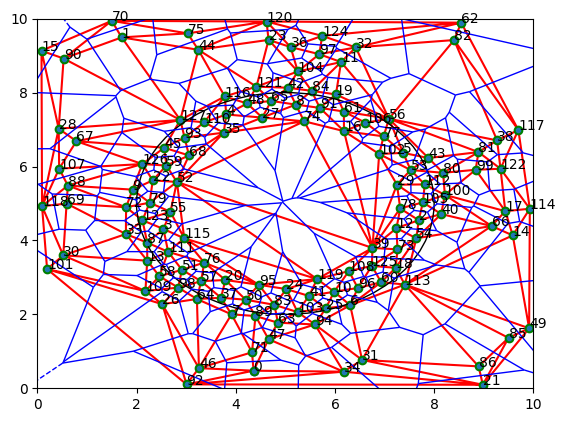

In [452]:
sites_np = sites.detach().cpu().numpy()
tri = Delaunay(sites_np)
voronoi_initial = Voronoi(sites_np)
fig, ax = plt.subplots()
voronoi_plot_2d(voronoi_initial, ax=ax, show_vertices=False, line_colors='blue')
ax.triplot(sites_np[:, 0], sites_np[:, 1], tri.simplices, color='red')
plt.scatter(sites_np[0, 0], sites_np[0, 1], color='blue')
plt.scatter(sites_np[:, 0], sites_np[:, 1], color='green')

#annotate the points with their index
for i, txt in enumerate(range(len(sites_np))):
    ax.annotate(txt, (sites_np[i, 0], sites_np[i, 1]))


plot_sdf(ax)
plt.xlim(0,10)
plt.ylim(0,10)


plt.savefig(f'{destination}multiple_'f'{sdf}_'f'{max_iter}.png')

plt.show()